# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общая информация

In [88]:
import pandas as pd 
import datetime as dt
import numpy as np
import seaborn as sns


In [89]:
data=pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.0",108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN
1,7,"3,350,000.0",40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0
2,10,"5,196,000.0",56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0
3,0,"64,900,000.0",159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0
4,2,"10,000,000.0",100.0,2018-06-19T00:00:00,2,3.0,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

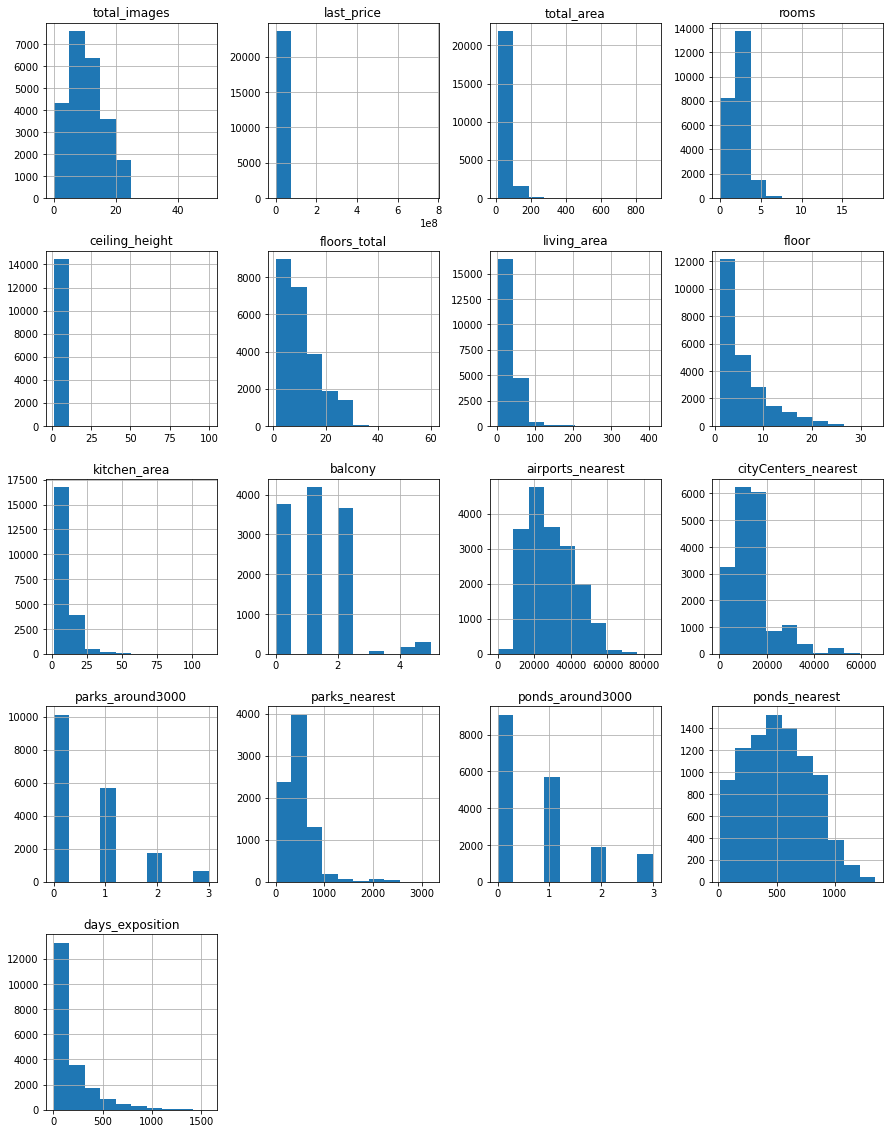

In [91]:
data.hist(figsize=(15, 20));

В результате изучения общей информации о датасете выяснено, что он состоит 23699 строк и 21 столбца, из них в 14 допущены пропуски в данных. Также тип данных не везде соответствует типу значений, находящимся в столбце. В столбцах 'floors_total','days_exposition','balcony' тип данных float, но данные значения могут быть только целыми числами. В столбце 'first_day_exposition' тип данных object, но он содержит день, месяц и год публикации. В гистограммах, построенных по каждому значению датасета, в столбцах 'total_area', 'floors_total', 'living_area', 'kitchen_area' есть аномальные значения. 

### Предобработка данных

#### Обработка пропусков

In [92]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [93]:
#замена пустых значений на 0 в отдельных столбцах
data['balcony']=data['balcony'].fillna(0)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [94]:
data['last_price'].sort_values()

8793         12,190.0
17456       430,000.0
14911       430,000.0
16274       440,000.0
17676       450,000.0
             ...     
15651   300,000,000.0
1436    330,000,000.0
14706   401,300,000.0
19540   420,000,000.0
12971   763,000,000.0
Name: last_price, Length: 23699, dtype: float64

In [95]:
data['locality_name'] = data['locality_name'].fillna('unknown')#замена пропусков в столбце с названиями мест

In [96]:
data['is_apartment'] = data['is_apartment'].fillna('False')

In [97]:

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [98]:
data['floors_total'] = data['floors_total'].fillna(data['floor'])#замена пустых значений в общем количестве этажей, на этаж квартиры


In [99]:
mean_area = data['living_area'].mean()/data['total_area'].mean()
data['living_area'] = data['living_area'].fillna(mean_area)


In [100]:
mean_kitchen_area = data['kitchen_area'].mean()/data['living_area'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna(mean_kitchen_area)

In [101]:
data['ceiling_height'].unique()
data['ceiling_height'].sort_values(ascending=False).head(30)


22869   100.0
22336    32.0
3148     32.0
21377    27.5
20478    27.0
5246     27.0
5807     27.0
10773    27.0
17857    27.0
22938    27.0
21824    27.0
4876     27.0
5669     26.0
18545    25.0
11285    25.0
355      25.0
6246     25.0
14382    25.0
4643     25.0
9379     25.0
5076     24.0
20507    22.6
17496    20.0
15061    14.0
22309    10.3
5863      8.3
15743     8.0
3474      8.0
17442     8.0
20264     6.0
Name: ceiling_height, dtype: float64

In [102]:
c_height_mean = data['ceiling_height'].mean()#заполняем оставшиеся пропуски средним значением высоты
data['ceiling_height'] = data['ceiling_height'].fillna(c_height_mean)
data['ceiling_height'].isna().sum()
data['ceiling_height'].unique()

array([  2.7      ,   2.7714989,   3.03     ,   2.5      ,   2.67     ,
         2.56     ,   3.05     ,   2.75     ,   2.6      ,   2.9      ,
         2.8      ,   2.55     ,   3.       ,   2.65     ,   3.2      ,
         2.61     ,   3.25     ,   3.45     ,   2.77     ,   2.85     ,
         2.64     ,   2.57     ,   4.15     ,   3.5      ,   3.3      ,
         2.71     ,   4.       ,   2.47     ,   2.73     ,   2.84     ,
         3.1      ,   2.34     ,   3.4      ,   3.06     ,   2.72     ,
         2.54     ,   2.51     ,   2.78     ,   2.76     ,  25.       ,
         2.58     ,   3.7      ,   2.52     ,   5.2      ,   2.87     ,
         2.66     ,   2.59     ,   2.       ,   2.45     ,   3.6      ,
         2.92     ,   3.11     ,   3.13     ,   3.8      ,   3.15     ,
         3.55     ,   3.16     ,   3.62     ,   3.12     ,   2.53     ,
         2.74     ,   2.96     ,   2.46     ,   5.3      ,   5.       ,
         2.79     ,   2.95     ,   4.06     ,   2.94     ,   3.8

In [103]:
#цикл для переноса точки в неверных значениях
for value in data['ceiling_height']:
    if value>10:
        print (data['ceiling_height']/10)
data = data.loc[(data['ceiling_height']<5)&(data['ceiling_height']>2)]#отбрасываем аномальные значения
data['ceiling_height'].unique()        


0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   0.4
23695   0.3
23696   0.3
23697   0.3
23698   0.2
Name: ceiling_height, Length: 23699, dtype: float64
0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   0.4
23695   0.3
23696   0.3
23697   0.3
23698   0.2
Name: ceiling_height, Length: 23699, dtype: float64
0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   0.4
23695   0.3
23696   0.3
23697   0.3
23698   0.2
Name: ceiling_height, Length: 23699, dtype: float64
0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   0.4
23695   0.3
23696   0.3
23697   0.3
23698   0.2
Name: ceiling_height, Length: 23699, dtype: float64
0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   0.4
23695   0.3
23696   0.3
23697   0.3
23698   0.2
Name: ceiling_height, Length: 23699, dtype: float64
0       0.3
1       0.3
2       0.3
3       0.3
4       0.3
         ..
23694   

array([2.7      , 2.7714989, 3.03     , 2.5      , 2.67     , 2.56     ,
       3.05     , 2.75     , 2.6      , 2.9      , 2.8      , 2.55     ,
       3.       , 2.65     , 3.2      , 2.61     , 3.25     , 3.45     ,
       2.77     , 2.85     , 2.64     , 2.57     , 4.15     , 3.5      ,
       3.3      , 2.71     , 4.       , 2.47     , 2.73     , 2.84     ,
       3.1      , 2.34     , 3.4      , 3.06     , 2.72     , 2.54     ,
       2.51     , 2.78     , 2.76     , 2.58     , 3.7      , 2.52     ,
       2.87     , 2.66     , 2.59     , 2.45     , 3.6      , 2.92     ,
       3.11     , 3.13     , 3.8      , 3.15     , 3.55     , 3.16     ,
       3.62     , 3.12     , 2.53     , 2.74     , 2.96     , 2.46     ,
       2.79     , 2.95     , 4.06     , 2.94     , 3.82     , 3.54     ,
       3.53     , 2.83     , 4.7      , 2.4      , 3.38     , 3.01     ,
       3.65     , 3.9      , 3.18     , 3.35     , 2.3      , 3.57     ,
       2.48     , 2.62     , 2.82     , 3.98     , 

В столбце 'ceiling_height' в большинстве значений в исходных данных было много редких и выбивающихся значений,которые были устранены путем переноса точки в числе влево на один десяток и удаления аномальных значений менее 2 метров и более 10.

In [104]:
data['total_area'].unique()

array([108.  ,  40.4 ,  56.  , ...,  66.86, 133.81,  76.75])

В случае с данным датасетом пропуски в данных могли возникнуть по следующим причинам:
1. Пользователь предоставил неполные данные
2. Нет данных об адресе недвижимости 
3. Нет данных о площади кухни
4. Произошла опечатка в процессе заполнения полей с данными
5. Пользователь не проставил отметки в ячейках с ответами "Да"-"Нет"

#### Преобразование типов

In [105]:
data['floors_total'].astype(int)

data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'],format = '%Y-%m-%d %H:%M:%S')

data['days_exposition'].astype('int',errors='ignore')

data['balcony'].astype(int)

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23648, dtype: int64

In [106]:

data['kitchen_area'].astype(float)

0       25.0
1       11.0
2        8.3
3        0.3
4       41.0
        ... 
23694   13.8
23695    8.5
23696    0.3
23697   23.3
23698    9.0
Name: kitchen_area, Length: 23648, dtype: float64

In [107]:
data['first_day_exposition'].unique()

array(['2019-03-07T00:00:00.000000000', '2018-12-04T00:00:00.000000000',
       '2015-08-20T00:00:00.000000000', ...,
       '2014-12-29T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [108]:
data['locality_name'].sort_values().unique()


array(['unknown', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск',
       'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород',
       'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино',
       'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово',
       'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино',
       'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф',
       'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк',
       'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно',
       'Шлиссельбург', 'городской поселок Большая Ижора',
       'городской поселок Янино-1', 'городской посёлок Будогощь',
       'городской посёлок Виллози', 'городской посёлок Лесогорский',
       'городской посёлок Мга', 'городской посёлок Назия',
       'городской посёлок Новоселье', 'городской посёлок Павлово',
       'городской посёлок Рощино', 'городской посёлок Свирьстрой',
       'город

In [109]:
data['locality_name'] = data['locality_name'].str.lower()#Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты. 
to_replace = ['городской поселок','поселок городского типа','поселок','посёлок','поселок поселок типа','поселок поселок']
data.replace(regex=to_replace, value = 'поселок',inplace=True)

In [110]:
data['locality_name'].sort_values().unique()

array(['unknown', 'бокситогорск', 'волосово', 'волхов', 'всеволожск',
       'выборг', 'высоцк', 'гатчина', 'городской поселок будогощь',
       'городской поселок виллози', 'городской поселок лесогорский',
       'городской поселок мга', 'городской поселок назия',
       'городской поселок новоселье', 'городской поселок павлово',
       'городской поселок рощино', 'городской поселок свирьстрой',
       'городской поселок советский', 'городской поселок фёдоровское',
       'городской поселок янино-1', 'деревня агалатово', 'деревня аро',
       'деревня батово', 'деревня бегуницы', 'деревня белогорка',
       'деревня большая вруда', 'деревня большая пустомержа',
       'деревня большие колпаны', 'деревня большое рейзино',
       'деревня большой сабск', 'деревня бор', 'деревня борисова грива',
       'деревня ваганово', 'деревня вартемяги', 'деревня вахнова кара',
       'деревня выскатка', 'деревня гарболово', 'деревня глинка',
       'деревня горбунки', 'деревня гостилицы', 'деревня 

In [111]:
data['kitchen_area'].unique()


array([ 25.      ,  11.      ,   8.3     ,   0.333046,  41.      ,
         9.1     ,  14.4     ,  18.9     ,   8.81    ,   6.5     ,
         8.5     ,   6.      ,   9.      ,   5.2     ,   8.      ,
         7.6     ,   5.6     ,  12.      ,   5.7     ,   6.1     ,
        19.6     ,  15.      ,   7.      ,   9.2     ,  11.7     ,
        13.4     ,  17.      ,   6.3     ,  11.6     ,   8.8     ,
        10.      ,  17.6     ,   7.5     ,   9.5     ,  50.      ,
        15.5     ,  10.7     ,  11.1     ,  20.      ,  11.9     ,
        16.      ,   5.3     ,  11.5     ,   7.2     ,   6.2     ,
        10.4     ,   7.1     ,   4.9     ,   7.3     ,  11.95    ,
        10.2     ,   6.4     ,   5.5     ,  13.      ,   8.4     ,
        23.6     ,  10.8     ,  18.3     ,   5.      ,   8.2     ,
        24.      ,  23.8     ,   6.6     ,  26.85    ,  15.4     ,
         7.8     ,  33.8     ,   5.4     ,  12.72    ,  12.2     ,
        19.      ,  12.4     ,   7.9     ,  10.3     ,   9.8  

In [112]:

data_copy = data.copy()
data.shape[0] 

23648

In [113]:
a = data['kitchen_area'].quantile(0.005)
b = data['kitchen_area'].quantile(0.995)

In [114]:
data_copy = data.loc[(data['kitchen_area']<b)&(data['kitchen_area']>a)]#

In [115]:
data_copy.shape[0]/data.shape[0] 

0.899018944519621

In [116]:
data_copy = data

In [117]:
data_copy.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,"23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","23,648.0","18,126.0","18,149.0","18,150.0","8,061.0","18,150.0","9,091.0","20,478.0"
mean,9.9,"6,528,587.0",60.3,2.1,2.7,10.7,31.7,5.9,9.6,0.6,"28,796.7","14,194.3",0.6,490.9,0.8,518.3,180.9
std,5.7,"10,815,583.1",35.5,1.1,0.2,6.6,23.0,4.9,6.4,1.0,"12,632.9","8,606.7",0.8,342.6,0.9,277.7,219.8
min,0.0,"12,190.0",12.0,0.0,2.2,1.0,0.6,1.0,0.3,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,"3,411,750.0",40.0,1.0,2.6,5.0,17.8,2.0,6.3,0.0,"18,579.0","9,238.0",0.0,288.0,0.0,294.0,45.0
50%,9.0,"4,650,000.0",52.0,2.0,2.8,9.0,29.0,4.0,9.0,0.0,"26,727.5","13,104.0",0.0,455.0,1.0,503.0,95.0
75%,14.0,"6,800,000.0",69.9,3.0,2.8,16.0,41.1,8.0,11.5,1.0,"37,284.0","16,293.0",1.0,612.0,1.0,730.0,232.0
max,50.0,"763,000,000.0",900.0,19.0,4.9,60.0,409.7,33.0,112.0,5.0,"84,869.0","65,968.0",3.0,"3,190.0",3.0,"1,344.0","1,580.0"


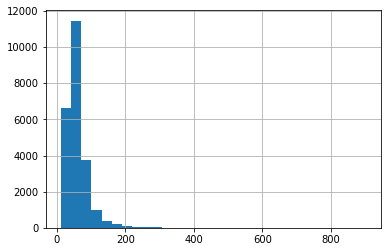

In [118]:
#код ревьюера
data['total_area'].hist(bins=30);

In [119]:
data=data.query('total_area<200')

In [120]:
data = data.query('last_price<100000000')# уберём квартиры со стоимостью более 100млн,так как они относятся к редким единичным объектам

In [121]:
#квартир с числом комнат более 6 очень небольшое количество, следовательно данные значения можно обрезать как аномальные
data = data.query('rooms<6')


In [122]:
data.shape[0] 

23329

### Посчитайте и добавьте в таблицу новые столбцы

In [123]:
data['price_1_m'] = data['last_price']/data['total_area']#площадь 1кв.м
pd.options.display.float_format = '{:,.1f}'.format


In [124]:
data['weekday'] = data['first_day_exposition'].dt.weekday#день недели
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_m,weekday
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,"120,370.4",3
1,7,"3,350,000.0",40.4,2018-12-04,1,2.8,11.0,18.6,1,False,False,False,11.0,2.0,поселок шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0,"82,920.8",1
2,10,"5,196,000.0",56.0,2015-08-20,2,2.8,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,"92,785.7",3
3,0,"64,900,000.0",159.0,2015-07-24,3,2.8,14.0,0.6,9,False,False,False,0.3,0.0,санкт-петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,"408,176.1",4
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,"100,000.0",1


In [125]:
data['month'] = data['first_day_exposition'].dt.month#месяц публикации
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_m,weekday,month
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,"120,370.4",3,3
1,7,"3,350,000.0",40.4,2018-12-04,1,2.8,11.0,18.6,1,False,False,False,11.0,2.0,поселок шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0,"82,920.8",1,12
2,10,"5,196,000.0",56.0,2015-08-20,2,2.8,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,"92,785.7",3,8
3,0,"64,900,000.0",159.0,2015-07-24,3,2.8,14.0,0.6,9,False,False,False,0.3,0.0,санкт-петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,"408,176.1",4,7
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,"100,000.0",1,6


In [126]:
data['year'] = data['first_day_exposition'].dt.year#год публикации
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_m,weekday,month,year
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,"120,370.4",3,3,2019
1,7,"3,350,000.0",40.4,2018-12-04,1,2.8,11.0,18.6,1,False,False,False,11.0,2.0,поселок шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0,"82,920.8",1,12,2018
2,10,"5,196,000.0",56.0,2015-08-20,2,2.8,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,"92,785.7",3,8,2015
3,0,"64,900,000.0",159.0,2015-07-24,3,2.8,14.0,0.6,9,False,False,False,0.3,0.0,санкт-петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,"408,176.1",4,7,2015
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,"100,000.0",1,6,2018


In [127]:
data['floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [128]:
#добавление столбца с типом этажа "первый", "последний", "другой" с использованием создания функции и метода apply
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type,axis=1) 

In [129]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_m,weekday,month,year,floor_type
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,"120,370.4",3,3,2019,другой
1,7,"3,350,000.0",40.4,2018-12-04,1,2.8,11.0,18.6,1,False,False,False,11.0,2.0,поселок шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0,"82,920.8",1,12,2018,первый
2,10,"5,196,000.0",56.0,2015-08-20,2,2.8,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,"92,785.7",3,8,2015,другой
3,0,"64,900,000.0",159.0,2015-07-24,3,2.8,14.0,0.6,9,False,False,False,0.3,0.0,санкт-петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,"408,176.1",4,7,2015,другой
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,"100,000.0",1,6,2018,другой


In [130]:
#добавление столбца расстояние до центра в км и округление до целого числа

data['cityCenters_nearest'] = data['cityCenters_nearest'].astype(int,errors='ignore')
data['cityCenters_nearest_km']=round(data['cityCenters_nearest']/1000)
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype(int,errors='ignore')
data['cityCenters_nearest_km']

0       16.0
1       19.0
2       14.0
3        7.0
4        8.0
        ... 
23694    4.0
23695    NaN
23696    NaN
23697   10.0
23698    NaN
Name: cityCenters_nearest_km, Length: 23329, dtype: float64

### Проведите исследовательский анализ данных

####  Изучение параметров 

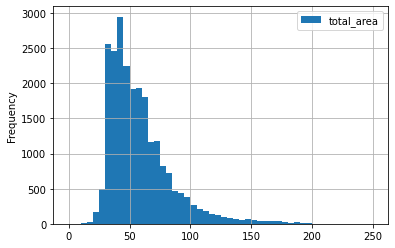

In [131]:
data.plot(kind='hist',y='total_area',bins=50,range=(0,250), grid=True );

In [132]:
data['total_area'].describe()

count   23,329.0
mean        57.8
std         25.7
min         12.0
25%         40.0
50%         51.6
75%         68.4
max        199.2
Name: total_area, dtype: float64

Вывод: Проанализировав гистограмму распределения общей площади, можно сделать вывод, что наиболее распространенное значение общей площади квартиры 30-50 кв.м. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 51,6 кв.м, а среднее значение 57,8 кв.м. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 25,7 единиц, следовательно выборка неоднородна, т.е.значения распределны неравномерно.

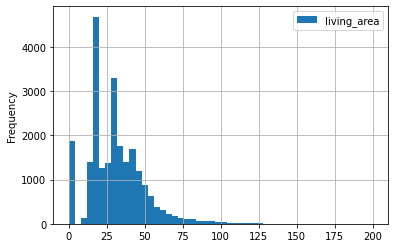

In [133]:

data.plot(kind='hist',y='living_area',bins=50,range=(0,200), grid=True );

In [134]:
data['living_area'].describe()

count   23,329.0
mean        30.4
std         18.3
min          0.6
25%         17.8
50%         29.0
75%         40.5
max        164.7
Name: living_area, dtype: float64

Вывод:Проанализировав гистограмму распределения жилой площади, можно сделать вывод, что наиболее распространенное значение жилой площади квартиры 30 кв.м., аномальные значения - меньше 20. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 29 кв.м, а среднее значение 30,4  кв.м. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 18,3 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

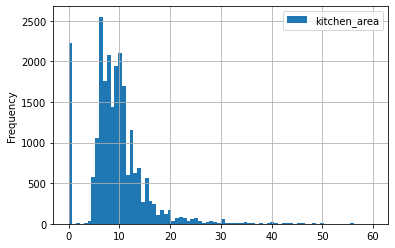

In [135]:
data.plot(kind='hist',y='kitchen_area',bins=80,range=(0,60), grid=True );

In [136]:
data['kitchen_area'].describe() 

count   23,329.0
mean         9.4
std          5.9
min          0.3
25%          6.3
50%          8.9
75%         11.3
max         93.2
Name: kitchen_area, dtype: float64

 Проанализировав гистограмму распределения площади кухни, можно сделать вывод, что наиболее распространенное значение  площади кухни 8 и 10 кв.м., аномальные значения - больше 30 кв.м. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 8,9 кв.м, а среднее значение 9,4 кв.м. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 5.9 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

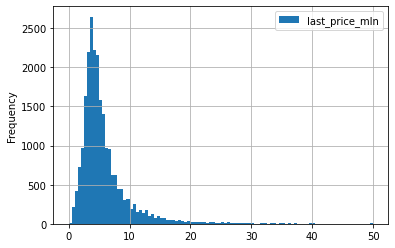

In [137]:
data['last_price_mln'] = data['last_price']/1000000
data.plot(kind='hist',y='last_price_mln',bins=100, range = (0,50) , grid=True );

In [138]:
data['last_price_mln'].describe() 

count   23,329.0
mean         5.9
std          5.3
min          0.0
25%          3.4
50%          4.6
75%          6.7
max         98.0
Name: last_price_mln, dtype: float64

 Проанализировав гистограмму распределения стоимости квартир, можно сделать вывод, что наиболее распространенное значение - 4-5 млн. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 4.6 млн, а среднее значение 5,9. Стандартное отклонение показывает, что значения в выборке отклоняются от среднего на 5,3 единицы, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.


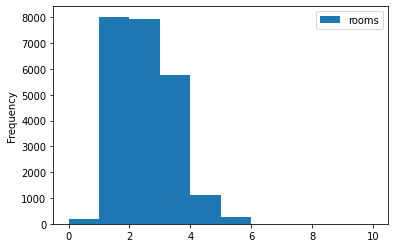

In [139]:
data.plot(kind='hist',y='rooms',bins=10,range=(0,10));

In [140]:
data['rooms'].describe() 

count   23,329.0
mean         2.0
std          1.0
min          0.0
25%          1.0
50%          2.0
75%          3.0
max          5.0
Name: rooms, dtype: float64

 Проанализировав гистограмму распределения количества комнат, можно сделать вывод, что наиболее распространенное значение 1-3 комнаты. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 2 и среднее значение 2. Стандартное отклонение показывает, что значения в выборке отклоняются от среднего на 1 единицу, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.


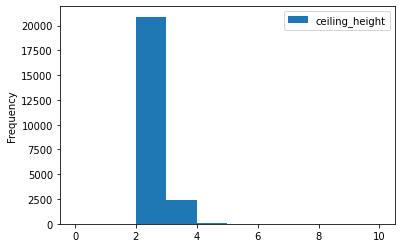

In [141]:
data.plot(kind='hist',y='ceiling_height',bins=10,range=(0,10));

In [142]:
data['ceiling_height'].describe()

count   23,329.0
mean         2.7
std          0.2
min          2.2
25%          2.6
50%          2.8
75%          2.8
max          4.8
Name: ceiling_height, dtype: float64

Проанализировав гистограмму распределения высоты потолков, можно сделать вывод, что наиболее распространенное значение 2.5м. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 2,8 м, а среднее значение 2.7 м. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 0,2 единицы, следовательно выборка однородна.

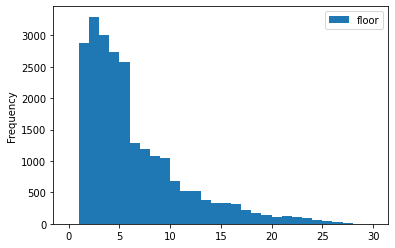

In [143]:
data.plot(kind='hist',y='floor',bins=30,range=(0,30));

In [144]:
data['floor'].describe() 

count   23,329.0
mean         5.9
std          4.9
min          1.0
25%          2.0
50%          4.0
75%          8.0
max         33.0
Name: floor, dtype: float64

Проанализировав гистограмму распределения количества этажей, можно сделать вывод, что наиболее распространенное значение до 2-6 этажей. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 4, а среднее значение 5,9. Стандартное отклонение показывает, что значения в выборке отклоняются от среднего на 4.9 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

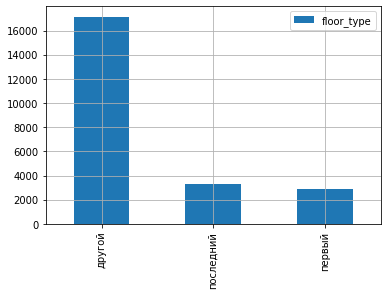

In [145]:
data['floor_type'].value_counts().plot(kind='bar',grid=True, legend=True); 

In [146]:
data['floor_type'].describe() 

count      23329
unique         3
top       другой
freq       17132
Name: floor_type, dtype: object

   В соответствии с графиком распределения типа этажей, большее количество относится к категории "другой"(более 16000), категория "последний" насчитывает 3000 позиций, а "первый" - около 3000. Использование метода describe() подтверждает, что есть 3 уникальных категории, топ занимает категория "другой" этаж, количество повторений - 17132.

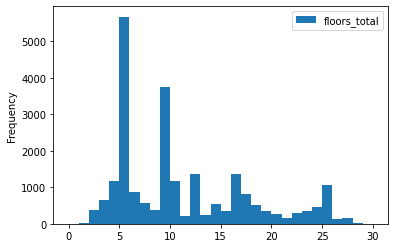

In [147]:
data.plot(kind='hist',y='floors_total',bins=30,range=(0,30));

In [148]:
data['floors_total'].describe() 

count   23,329.0
mean        10.7
std          6.6
min          1.0
25%          5.0
50%          9.0
75%         16.0
max         60.0
Name: floors_total, dtype: float64

Проанализировав гистограмму распределения общего количества этажей, можно сделать вывод, что наиболее распространенное значение 5 и 10 этажей, аномальные значения - больше 25. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 9, а среднее значение 10,7. Стандартное отклонение показывает, что значения в выборке отклоняются от среднего на 6,6 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

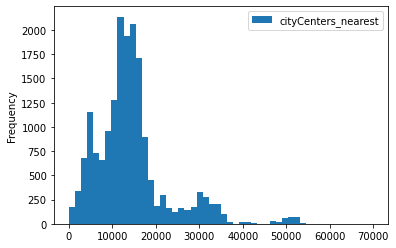

In [149]:

data.plot(kind='hist',y='cityCenters_nearest',bins=50,range=(0,70000));

In [150]:
data['cityCenters_nearest'].describe()

count   17,837.0
mean    14,327.2
std      8,579.9
min        181.0
25%      9,496.0
50%     13,188.0
75%     16,361.0
max     65,968.0
Name: cityCenters_nearest, dtype: float64

Проанализировав гистограмму распределения расстояния до цента, можно сделать вывод, что наиболее распространенное значение 15000 м, аномальные значения - больше 35000м. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 13188м, а среднее значение 14327. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 8379 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

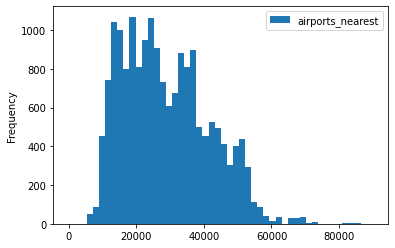

In [151]:
data['airports_nearest'].astype(float)

data.plot(kind='hist',y='airports_nearest',bins=50,range=(0,90000));


In [152]:
data['airports_nearest'].describe()

count   17,817.0
mean    28,846.1
std     12,698.5
min          0.0
25%     18,492.0
50%     26,881.0
75%     37,407.0
max     84,869.0
Name: airports_nearest, dtype: float64

Вывод: Проанализировав гистограмму распределения расстояния до аэропорта, можно сделать вывод, что наиболее распространенное значение расстояния 18000 и 36000, аномальные значения - больше 60000 м. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 26881 м, а среднее значение 28846 м. Стандартное отклонение показывает, что значения в выборке откланяются от среднего на 12698 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

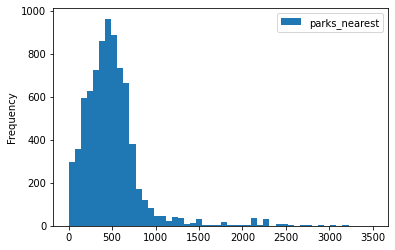

In [153]:
#data = data.query('parks_nearest!=" "')
data.plot(kind='hist',y='parks_nearest',bins=50,range=(0,3500));


In [154]:
data['parks_nearest'].describe()

count   7,848.0
mean      492.6
std       344.3
min         1.0
25%       288.0
50%       456.0
75%       614.0
max     3,190.0
Name: parks_nearest, dtype: float64

Проанализировав гистограмму распределения расстояния до парков, можно сделать вывод, что наиболее распространенное значение расстояния до ближайшего парка 500м. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 456 м, а среднее значение 492 м. Стандартное отклонение показывает, что значения в выборке отклоняются от среднего на 345 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

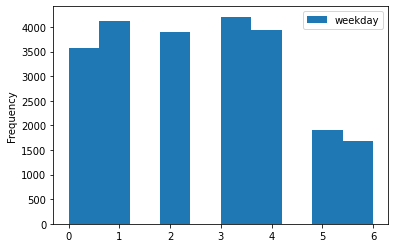

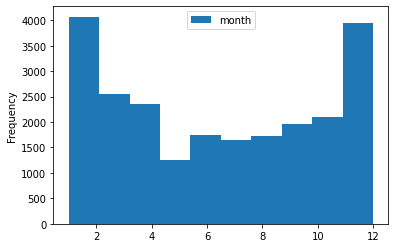

In [155]:

data.plot(kind='hist',y=['weekday']);
data.plot(kind='hist',y=['month']);

In [156]:
data['weekday'].describe()

count   23,329.0
mean         2.6
std          1.8
min          0.0
25%          1.0
50%          3.0
75%          4.0
max          6.0
Name: weekday, dtype: float64

In [157]:
data['month'].describe()

count   23,329.0
mean         6.4
std          3.5
min          1.0
25%          3.0
50%          6.0
75%         10.0
max         12.0
Name: month, dtype: float64

По гистограммам распределения даты и месяца публикации объявления можно сделать вывод, что наиболее часто объявления о продаже появляются в будни и в январе, и декабре. Что подтверждает и использование метода describe. 

#### Изучение скорости продажи квартир

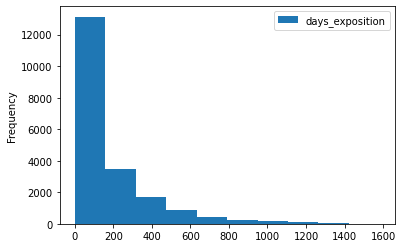

In [158]:
data.plot(kind='hist',y='days_exposition');

In [159]:
data['days_exposition'].describe()

count   20,242.0
mean       179.5
std        218.2
min          1.0
25%         45.0
50%         95.0
75%        229.0
max      1,580.0
Name: days_exposition, dtype: float64

Вывод: Проанализировав гистограмму распределения количества дней, в течении которых квартира находилась на продаже, можно сделать вывод, что к быстрым продажам можно отнести квартиры, проданные за период времени до 180 дней, к аномально долгим - от 1000 дней, т.е. 3 года и более. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 95 дней, а среднее значение 179 дней. Но стандартное отклонение очень велико, оно показывает, что значения в выборке откланяются от среднего на 218 единиц, следовательно выборка неоднородна, что еще раз подтверждает наличие выбросов в наборе данных.

#### Определение факторов, влияющих на стоимость 


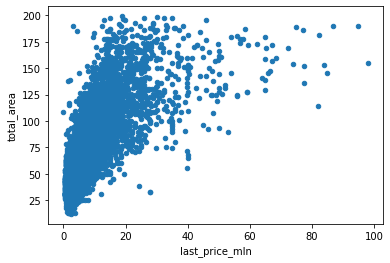

In [160]:
data.plot(x='last_price_mln', y='total_area',kind='scatter');


На данном графике можно увидеть наличие зависимости стоимости жилья от общей площади.Матрица корелляции подтверждает эту зависимость, коэффициент равен 0,7.

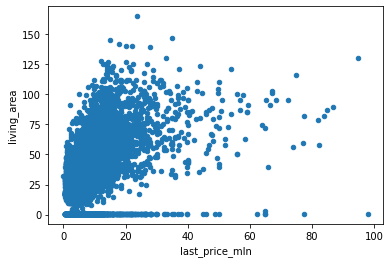

In [161]:
data.plot(x='last_price_mln', y='living_area', kind='scatter');

На данном графике можно увидеть наличие зависимости стоимости жилья от жилой площади, хоть и менее выраженную.Матрица корелляции подтверждает эту зависимость, коэффициент равен 0,5.

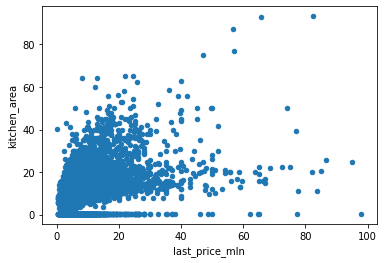

In [162]:
data.plot(x='last_price_mln', y='kitchen_area', kind='scatter');

На данном графике можно увидеть наличие зависимости стоимости жилья от площади кухни, хоть и еще менее выраженную.Матрица корелляции показывает коэффициент равный 0,5.

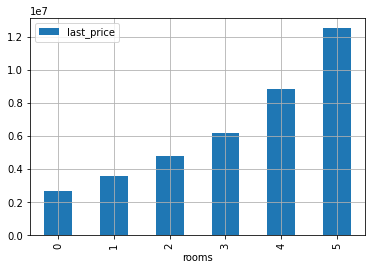

In [163]:
room_group = data.groupby('rooms')['last_price'].median()
#группировка по количеству комнат с расчетом медианной цены для каждой группы
room_group.plot(kind='bar',grid=True, legend=True);

На данном графике можно увидеть наличие зависимости стоимости жилья от количества комнат, хоть в матрица корелляции показывает коэффициент равный 0.4, на графике мы видим рост цены.

In [164]:
price_corr = data.loc[:,['last_price','total_area','living_area','kitchen_area','rooms']]
price_corr.corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.0,0.7,0.5,0.5,0.4
total_area,0.7,1.0,0.8,0.5,0.8
living_area,0.5,0.8,1.0,0.4,0.7
kitchen_area,0.5,0.5,0.4,1.0,0.2
rooms,0.4,0.8,0.7,0.2,1.0


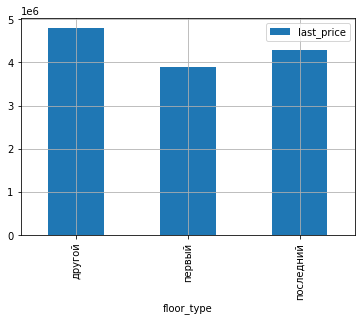

In [165]:
type_group = data.groupby('floor_type')['last_price'].median()#группировка по типу этажа с расчетом средней цены для каждой группы
type_group.plot(kind='bar',grid=True, legend=True);

На графике можно увидеть, что большой разницы в стоимости квартиры в зависимости от категории этажа нет. Данный фактор мало влияет на стоимость жилья.

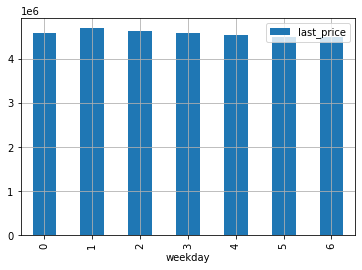

In [166]:
weekday_group = data.groupby('weekday')['last_price'].median()
weekday_group.plot(kind='bar',grid=True, legend=True);

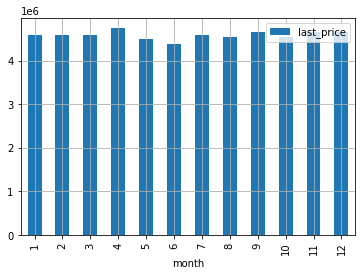

In [167]:
month_group = data.groupby('month')['last_price'].median()
month_group.plot(kind='bar',grid=True, legend=True);

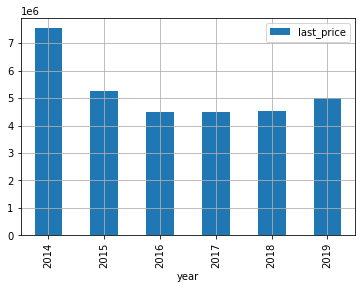

In [168]:
year_group = data.groupby('year')['last_price'].median()
year_group.plot(kind='bar',grid=True, legend=True);



На графиках зависимости числа и месяца публикации объявления от медианной стоимости жилья связи между параметрами не выявлено. На графике с годом публикации объявления видно, что стоимость жилья в 2014 году была больше, чем в 2015-2019. В эти годы стоимость находилась примерно на одном уровне.

#### Определение наибольшего количества объявлений

In [169]:

locality = data.pivot_table(index='locality_name',values=['price_1_m','first_day_exposition'],\
                            aggfunc=({'price_1_m':'mean','first_day_exposition':'count'})).sort_values(by='first_day_exposition',ascending=False)

locality.head(10)

,first_day_exposition,price_1_m
locality_name,,
санкт-петербург,15393,"113,139.3"
поселок мурино,554,"85,656.2"
поселок шушары,440,"78,677.4"
всеволожск,397,"68,719.3"
пушкин,363,"103,213.5"
колпино,337,"75,333.3"
поселок парголово,326,"90,332.3"
гатчина,306,"68,757.7"
деревня кудрово,299,"92,473.5"


In [170]:
locality.sort_values(by='price_1_m')#минимальная цена

,first_day_exposition,price_1_m
locality_name,,
деревня старополье,3,"11,206.2"
поселок станции свирь,2,"11,481.5"
деревня вахнова кара,1,"11,688.3"
деревня выскатка,2,"12,335.5"
поселок совхозный,2,"12,629.1"
...,...,...
сестрорецк,182,"101,912.3"
пушкин,363,"103,213.5"
поселок репино,4,"104,238.6"


In [171]:
locality.sort_values(by='price_1_m',ascending=False)#максимальная цена

,first_day_exposition,price_1_m
locality_name,,
зеленогорск,24,"115,122.8"
санкт-петербург,15393,"113,139.3"
поселок репино,4,"104,238.6"
пушкин,363,"103,213.5"
сестрорецк,182,"101,912.3"
...,...,...
поселок совхозный,2,"12,629.1"
деревня выскатка,2,"12,335.5"
деревня вахнова кара,1,"11,688.3"


#### Стоимость квартир в Санкт-Петербурге в зависимости от расстояния от центра

In [172]:
sp_flat = data.query('locality_name=="санкт-петербург"')
sp_flat

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1_m,weekday,month,year,floor_type,cityCenters_nearest_km,last_price_mln
0,20,"13,000,000.0",108.0,2019-03-07,3,2.7,16.0,51.0,8,False,False,False,25.0,0.0,санкт-петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN,"120,370.4",3,3,2019,другой,16.0,13.0
2,10,"5,196,000.0",56.0,2015-08-20,2,2.8,5.0,34.3,4,False,False,False,8.3,0.0,санкт-петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0,"92,785.7",3,8,2015,другой,14.0,5.2
3,0,"64,900,000.0",159.0,2015-07-24,3,2.8,14.0,0.6,9,False,False,False,0.3,0.0,санкт-петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0,"408,176.1",4,7,2015,другой,7.0,64.9
4,2,"10,000,000.0",100.0,2018-06-19,2,3.0,14.0,32.0,13,False,False,False,41.0,0.0,санкт-петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0,"100,000.0",1,6,2018,другой,8.0,10.0
7,5,"7,915,000.0",71.6,2019-04-18,2,2.8,24.0,0.6,22,False,False,False,18.9,2.0,санкт-петербург,"23,982.0","11,634.0",0.0,NaN,0.0,NaN,NaN,"110,544.7",3,4,2019,другой,12.0,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,"3,550,000.0",35.3,2018-02-28,1,2.9,15.0,16.3,4,False,False,False,9.1,2.0,санкт-петербург,"17,284.0","16,081.0",1.0,353.0,2.0,652.0,29.0,"100,566.6",2,2,2018,другой,16.0,3.5
23690,3,"5,500,000.0",52.0,2018-07-19,2,2.8,5.0,31.0,2,False,False,False,6.0,0.0,санкт-петербург,"20,151.0","6,263.0",1.0,300.0,0.0,NaN,15.0,"105,769.2",3,7,2018,другой,6.0,5.5
23691,11,"9,470,000.0",72.9,2016-10-13,2,2.8,25.0,40.3,7,False,False,False,10.6,1.0,санкт-петербург,"19,424.0","4,489.0",0.0,NaN,1.0,806.0,519.0,"129,904.0",3,10,2016,другой,4.0,9.5
23694,9,"9,700,000.0",133.8,2017-03-21,3,3.7,5.0,73.3,3,False,False,False,13.8,0.0,санкт-петербург,"24,665.0","4,232.0",1.0,796.0,3.0,381.0,NaN,"72,490.8",1,3,2017,другой,4.0,9.7


In [173]:
price_km = sp_flat.pivot_table(index='cityCenters_nearest_km', values='price_1_m',aggfunc='mean')
price_km['km'] = price_km.index
price_km

,price_1_m,km
cityCenters_nearest_km,,
0.0,"224,886.0",0.0
1.0,"149,362.6",1.0
2.0,"147,414.9",2.0
3.0,"121,445.5",3.0
4.0,"128,318.2",4.0
5.0,"137,724.8",5.0
6.0,"145,713.6",6.0
7.0,"153,373.7",7.0
8.0,"124,103.2",8.0


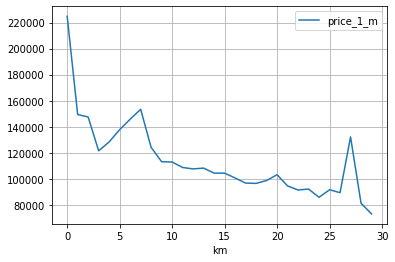

In [174]:
#price_per_km.plot(x='km', y='price_per_metre' ,kind='line')
price_km.plot(x='km',y='price_1_m',kind='line',grid=True);


Самая высокая стоимость квартир на расстоянии примерно в центре, далее по мере удаленности цена снижается и еще один пик можнор увидеть на расстоянии около 8 км от центра города, далее цена постепенно снижается и еще один пик мы видим на расстоянии 27 км от центра(это квартиры в пригороде). Зависимость стоимости квадратного метра от расстояния от центра города очевидно существует, чем дальше от центра санкт-Петербурга находится недвижимость, тем ниже цена квадратного метра.

### Общий вывод

1.Проанализировав гистограмму распределения общей площади, можно сделать вывод, что наиболее распространенное значение общей площади квартиры 50-60 кв.м., аномальные значения - больше 200 кв.м. Такие значения можно отнести к выбросам. 
2.Проанализировав гистограмму распределения жилой площади, можно сделать вывод, что наиболее распространенное значение жилой площади квартиры 30 кв.м., аномальные значения - меньше 20 и больше 200 кв.м. 
3.Проанализировав гистограмму распределения площади кухни, можно сделать вывод, что наиболее распространенное значение площади кухни 8 и 12 кв.м., аномальные значения - больше 30 кв.м. 
4.Проанализировав гистограмму распределения стоимости квартир, можно сделать вывод, что наиболее распространенное значение - 4-5 млн., аномальные значения - больше 200 млн. 
5.Проанализировав гистограмму распределения количества комнат, можно сделать вывод, что наиболее распространенное значение 1-3 комнаты, аномальные значения - больше 6 комнат.
6.Проанализировав гистограмму распределения высоты потолков, можно сделать вывод, что наиболее распространенное значение 2.5м.
7.Проанализировав гистограмму распределения количества этажей, можно сделать вывод, что наиболее распространенное значение до 2-6 этажей.
8.В соответствии с графиком распределения типа этажей, большее количество относится к категории "другой"(более 16000), категория "последний" насчитывает 3000 позиций, а "первый" - около 3000.
9.Проанализировав гистограмму распределения общего количества этажей, можно сделать вывод, что наиболее распространенное значение 5 и 10 этажей, аномальные значения - больше 25. 
10.Проанализировав гистограмму распределения расстояния до цента, можно сделать вывод, что наиболее распространенное значение 15000 м, аномальные значения - больше 35000м. 
11.Проанализировав гистограмму распределения расстояния до аэропорта, можно сделать вывод, что наиболее распространенное значение расстояния 18000 и 36000
12.Проанализировав гистограмму распределения расстояния до парков, можно сделать вывод, что наиболее распространенное значение расстояния до ближайшего парка 500м
13.По гистограммам распределения даты и месяца публикации объявления можно сделать вывод, что наиболее часто объявления о продаже появляются в среду и в январе и декабре.
14.Проанализировав гистограмму распределения количества дней, в течении которых квартира находилась на продаже, можно сделать вывод, что к быстрым продажам можно отнести квартиры, проданные за период времени до 180 дней, к аномально долгим - от 1000 дней, т.е. 3 года и более. Такие значения можно отнести к выбросам. Использование метода describe() подтверждает, что медиана в данном распределении находится на значении 103 дня, а среднее значение 182 дня.
15. Самая высокая стоимость квартир на расстоянии примерно в центре, далее по мере удаленности цена снижается и еще один пик можнор увидеть на расстоянии около 8 км от центра города, далее цена постепенно снижается и еще один пик мы видим на расстоянии 27 км от центра(это квартиры в пригороде). Зависимость стоимости квадратного метра от расстояния от центра города очевидно существует, чем дальше от центра санкт-Петербурга находится недвижимость, тем ниже цена квадратного метра.
16.Выявлена зависимость стоимости жилья от общей площади, жилой площади, площади кухни и количества комнат.
17.Наиболее высокая стоимость квадратного метра в Зеленогорске, минимальная в деревне Старополье, наибольшее количество объявлений о продаже в Санкт -Петербурге.